In [30]:
#Packages 
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob 
import pickle
import re
import random
import sklearn
import spacy
nlp= spacy.blank('es')
import matplotlib.pyplot as plt
import string 
import nltk
from nltk.probability import FreqDist
punctuation= list(string.punctuation)
other_pnt=['!','¡', '¿'] #insert spanish punctuation

#Loading modefrom flair.data import Sentence
from flair.data import Sentence
from flair.models import SequenceTagger
import pathlib
import os 
if os.name == 'nt': # Minor patch needed if you are running from Windows
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
  
tagger = SequenceTagger.load("lirondos/anglicisms-spanish-flair-cs")

data_path= 'D:/CCiL/Inter_ling/data'


2024-02-15 12:52:31,345 SequenceTagger predicts: Dictionary with 8 tags: <unk>, O, B-ENG, I-ENG, B-OTHER, I-OTHER, <START>, <STOP>


In [2]:
#Example of how the model works 
text = "tengo la cuenta petada de likes de mis followers, me encanta ser influencer."

sentence = Sentence(text)

# predict tags
tagger.predict(sentence)

# print sentence
print(sentence)

# print predicted borrowing spans

for entity in sentence.get_spans():
   print(entity)


Sentence[15]: "tengo la cuenta petada de likes de mis followers, me encanta ser influencer." → ["likes"/ENG, "followers"/ENG, "influencer"/ENG]
Span[5:6]: "likes" → ENG (0.9979)
Span[8:9]: "followers" → ENG (0.992)
Span[13:14]: "influencer" → ENG (0.9163)


In [4]:
#Reading of dataframe
directory_path="comments/output*"#direction of file location 
files_path= glob.glob(directory_path)
dfs=[]
for file in files_path:
    df= pd.read_csv(file)
    dfs.append(df)
m_df= pd.concat(dfs, ignore_index=True)
m_df["Comment date"]=pd.to_datetime(m_df["Comment date"])
m_df = m_df.dropna(subset=['Comment'])
m_df= m_df.drop_duplicates(subset=['Comment'])
print(m_df.shape)

(696306, 8)


In [19]:
#Balances data

def delete_entries_year(df, year, n_samples):
    indices_year = df[df["Comment date"].dt.year == year].index.to_numpy()
    indices_delete = np.random.choice(indices_year, size=n_samples, replace=False)
    print(indices_delete)
    return df.drop(indices_delete)


print(m_df.shape)
m_df = delete_entries_year(m_df, 2017,50000)
m_df = delete_entries_year(m_df, 2020, 50000)
m_df = delete_entries_year(m_df, 2018, 40000)

(696306, 8)
[770148 548463  33074 ... 381790 555114 376586]
[799857 162220 206799 ... 226017 152689 230618]
[782595 446088 572800 ... 395524  68395 396631]


In [60]:
#Counts number of comments per year
years= [2010, 2011, 2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
p_years_values=[]
cont = 0
for i in years:
    year_to_filter=i
    filtered_df=m_df[m_df["Comment date"].dt.year == year_to_filter] #filter dataframe by year
    num_entries = len(filtered_df)# Get the number of entries in the filtered DataFrame
    cont += num_entries
    p_years_values.append(num_entries)
    print(f'{i} comments:{num_entries}')
print(f'Total number of comments:{cont}')

2010 comments:342
2011 comments:8316
2012 comments:45452
2013 comments:46152
2014 comments:33089
2015 comments:43561
2016 comments:66027
2017 comments:108606
2018 comments:97130
2019 comments:57683
2020 comments:109501
2021 comments:49433
2022 comments:17063
2023 comments:13622
Total number of comments:695977


In [15]:
def extract_comments_score(transformer, m_df, year):
  #Empty list for storing analysis 
  clean_comments= []
  
  df = m_df[m_df["Comment date"].dt.year == year]
  comments = df['Comment'].values
  for i in tqdm(comments):
    sentence=Sentence(i)
    tagger.predict(sentence)
    x= list(sentence.get_spans())
    clean_comments.append(x)
  return clean_comments


In [37]:

def counting_df(comments, year):
    items= list(comments)
    count= [] #Counting borrowings in dataframe
    for i in items:
        borrow = len(i)
        count.append(borrow)
    df= m_df[m_df["Comment date"].dt.year == year]
    df["Borrowings"]=count #Appends output of transformer to df
    df['Analysis']=items
    x= 'outputs/output_' + str(year) +'.csv'
    df.to_csv(x)

    return df 


In [44]:
comments_2023 = extract_comments_score(tagger, m_df, 2023)
counting_2023= counting_df(comments_2023, 2023)
print(f'Lenght of the final list:{len(comments_2023)}')

100%|██████████| 13622/13622 [17:47<00:00, 12.76it/s] 
C:\Users\aleja\AppData\Local\Temp\ipykernel_6308\1335839854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Borrowings"]=count #Appends output of transformer to df
C:\Users\aleja\AppData\Local\Temp\ipykernel_6308\1335839854.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis']=items


Lenght of the final list:13622


To compute statistical analysis, load the "clean_comments" file, as the processing of the sentences can take a long time to load. 

In [24]:
#Stats 
path= "D:\CCiL\Inter_ling\data\outputs\outputs"
x= path + "\output_*"

#Read new dataframe
files_path= glob.glob(x)
data =[]
for file in files_path:
    df= pd.read_csv(file)
    data.append(df)
all_comments= pd.concat(data, ignore_index=True)


In [25]:
#Counting words in each comment
comments= all_comments['Comment'].values
sentences_len= []
for i in comments:
    doc= nlp(i)
    doc_1=[token.text for token in doc] #Tokens
    doc_2= [t for t in doc_1 if t not in punctuation] #Removes punctuation
    l_sent= len(doc_2) 
    sentences_len.append(l_sent)
all_comments['Total word count']=sentences_len


In [26]:
#Correlation of year and number of anglicisms produced. Not included in written essay.
year_i= pd.to_datetime(all_comments["Comment date"]).dt.year.values
borrow_i=all_comments["Borrowings"].values

u_year = np.mean(year_i)
u_borrow = np.mean(borrow_i)

x_values = np.vstack((year_i - u_year, borrow_i - u_borrow))
R = (1/x_values.shape[1])*(x_values @ x_values.T)

var_years = R[0, 0]
var_borrowings = R[1, 1]

coef_corr = R[0, 1]/(np.sqrt(var_years)*np.sqrt(var_borrowings))

coef_corr

0.055822002217847694

In [27]:
#Calculation of frequency
years= [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
p_years_values=[]
for i in years:
    year_to_filter=i
    column_name = 'Borrowings'
    value_threshold = 1
    filtered_db=all_comments[pd.to_datetime(all_comments["Comment date"]).dt.year == year_to_filter] #filter dataframe by year
    counting= filtered_db[filtered_db[column_name] >= value_threshold]# Filter the DataFrame based on the condition
    num_entries = len(counting)# Get the number of entries in the filtered DataFrame
    p_anglicism= num_entries / (len(filtered_db))
    print(p_anglicism) 
    p_years_values.append(p_anglicism)

0.08177857960045763
0.07915149939330907
0.14234337695306598
0.1405844677578568
0.12934102715555756
0.13592464935330853
0.1518816733765097
0.1580014909071997
0.1773583637249794
0.14842311815993364
0.1343843403856297
0.18793128762296285


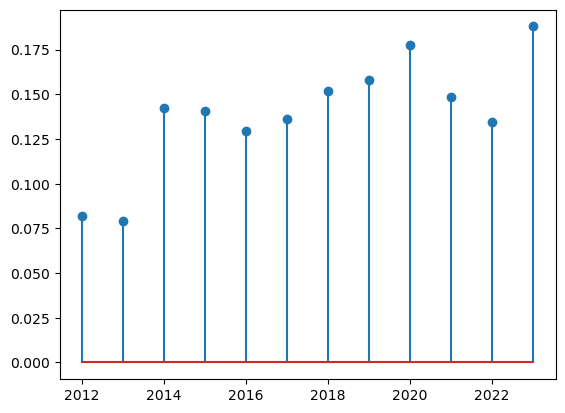

<Figure size 640x480 with 0 Axes>

In [28]:
plt.stem(years, p_years_values)
#plt.ylim([0, 0.2])
plt.show()
plt.savefig("frequency_borrowings")

1.3225719666397633
1.2811387900355873
1.343524416135881
1.2880470280862182
1.1878220140515223
1.2175495857393923
1.2020283508124927
1.2340355497037525
1.276509049559367
1.2097587569851438
1.2839075447012647
1.17265625


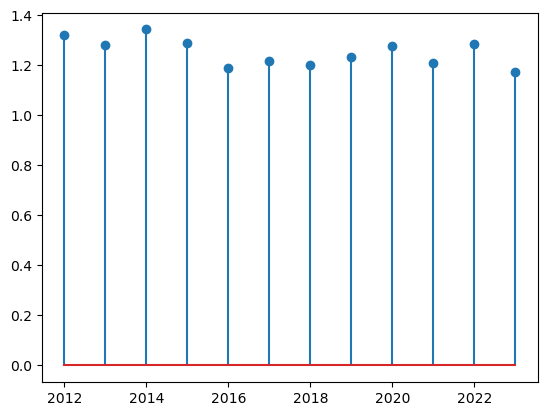

In [29]:
#Mean of anglicisms for each year
prob_ang= []
for i in years:
    year_to_filter=i
    column_name = 'Borrowings'
    value_threshold = 1
    filtered_db=all_comments[pd.to_datetime(all_comments["Comment date"]).dt.year == year_to_filter] #filter dataframe by year
    counting= filtered_db[filtered_db[column_name].values >= value_threshold]# Filter the DataFrame based on the condition
    c_values= np.sum(counting[column_name].values)
    num_entries = len(counting)# Get the number of entries in the filtered DataFrame
    p_anglicism= c_values / (len(counting))
    print(p_anglicism) 
    prob_ang.append(p_anglicism)

plt.stem(years, prob_ang)
#plt.ylim([0, 0.2])
plt.savefig("mean_num_borrow.png")
plt.show()


In [35]:
#Word frequency of anglicisms per year 
def freq_ang_per_year(year_to_filter):
    filtered_df= all_comments[pd.to_datetime(all_comments["Comment date"]).dt.year == year_to_filter] #filter dataframe by year
    anglicism_comments= filtered_df[filtered_df["Analysis"]!= '[]']
    pattern= r'(?<=\[")[^"]+(?="\s*→)'
    data= anglicism_comments["Analysis"]
    df = pd.DataFrame(data)
    # Define the regex pattern
    pattern = r'"([^"]+)"\s*→'
    # Extract the word using regex
    df['word'] = df['Analysis'].str.extract(pattern)
    words= list(df['word'].values) # List of all anglicisms 
    clean_words=[] #Empty list for storing all words 
    for i in words:
        if " " in i:
            x= i.split(' ')
            for w in x:
                clean_words.append(w)
        else:
            clean_words.append(i)
    
    words_not_ang= ['quot', 'a', 'href'] #words that are detected as anglicism but are marks from youtube notation
    clean_words= [w for w in clean_words if w not in words_not_ang]
    freq= FreqDist(clean_words)
    freq_df= pd.DataFrame(list(freq.items()), columns = ["Word","Frequency"]) 
    freq_df['Year']=year_to_filter
    freq_df= freq_df.sort_values(by='Frequency', ascending=False)
    return freq_df

def analysis_to_csv(year): #For deploying previous function and storing the output in a csv
    freq= freq_ang_per_year(year)
    x='outputs/frequencies/freq_' + str(year) +'.csv'
    freq.to_csv(x)

freq_ang_per_year(2012)

,Word,Frequency,Year
471,meh,233,2012
640,muffins,184,2012
0,like,139,2012
78,tutorial,60,2012
5,tips,59,2012
...,...,...,...
457,myspace.,1,2012
462,e-mail,1,2012
463,city,1,2012
465,kinect,1,2012


In [36]:
#If you need to store output in csv, decomment and run. Otherwise, continue in the next cell for visualization of the data.
#years= [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
#for i in years:
 #   analysis_to_csv(i)
    

In [37]:
#For loading the CSVs with extracted anglicisms and frequencies 

#Reading dataframe 

path= "D:/CCiL/Inter_ling/data/outputs/frequencies"
x= path + "/freq_*"

years= [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023] 

#Read new dataframe
files_path= glob.glob(x)
data =[]
for file in files_path:
    df= pd.read_csv(file)
    data.append(df)
df_ang= pd.concat(data, ignore_index=True)
df_ang

,Unnamed: 0,Word,Frequency,Year
0,471,meh,233,2012
1,640,muffins,184,2012
2,0,like,139,2012
3,78,tutorial,60,2012
4,5,tips,59,2012
...,...,...,...,...
11402,212,kill,1,2023
11403,208,comeback,1,2023
11404,207,hallowheen,1,2023
11405,206,tryhards,1,2023


In [62]:
def filter_a_df(name_of_dataframe, column_name_i , year):
    column_name = column_name_i
    filtered_db=name_of_dataframe[name_of_dataframe[column_name] == year] #filter dataframe by year
    word_frequencies = dict(zip(filtered_db['Word'].astype(str), filtered_db['Frequency'].astype(int)))
    return word_frequencies

df_i= filter_a_df(df_ang, "Year", 2023)

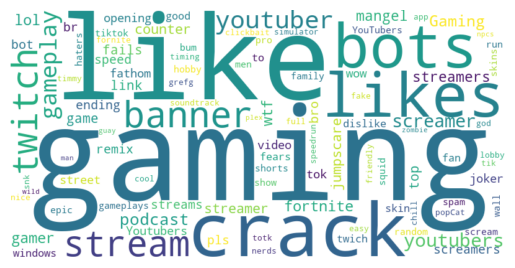

In [63]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100, font_step=2)
wordcloud.generate_from_frequencies(df_i)
# Display word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()